# Analisi Strategia Momentum - Commodities

Analisi dettagliata della strategia momentum basata sul concetto:
- Se ieri ha guadagnato (ritorno > 0), investi oggi con long equal weight
- Strategia applicata su 15 commodity futures

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Imposta stile grafici
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Librerie caricate con successo!")

Librerie caricate con successo!


## 1. Caricamento Risultati

In [6]:
# Carica i risultati della strategia momentum
results_dir = Path('results')

# Carica i dati salvati dal backtest
strategy_returns = pd.read_csv(results_dir / 'momentum_returns.csv', index_col=0, parse_dates=True)
equity_curve = pd.read_csv(results_dir / 'momentum_equity_curve.csv', index_col=0, parse_dates=True)
weights = pd.read_csv(results_dir / 'momentum_weights.csv', index_col=0, parse_dates=True)

# Converti le series in array 1D se necessario
if strategy_returns.shape[1] == 1:
    strategy_returns = strategy_returns.iloc[:, 0]
if equity_curve.shape[1] == 1:
    equity_curve = equity_curve.iloc[:, 0]

print(f"Periodo analisi: {strategy_returns.index.min().date()} - {strategy_returns.index.max().date()}")
print(f"Giorni di trading: {len(strategy_returns)}")
print(f"Commodity tracking: {weights.shape[1]}")

Periodo analisi: 2010-01-06 - 2025-08-08
Giorni di trading: 3921
Commodity tracking: 15


## 2. Visualizzazione Equity Curve

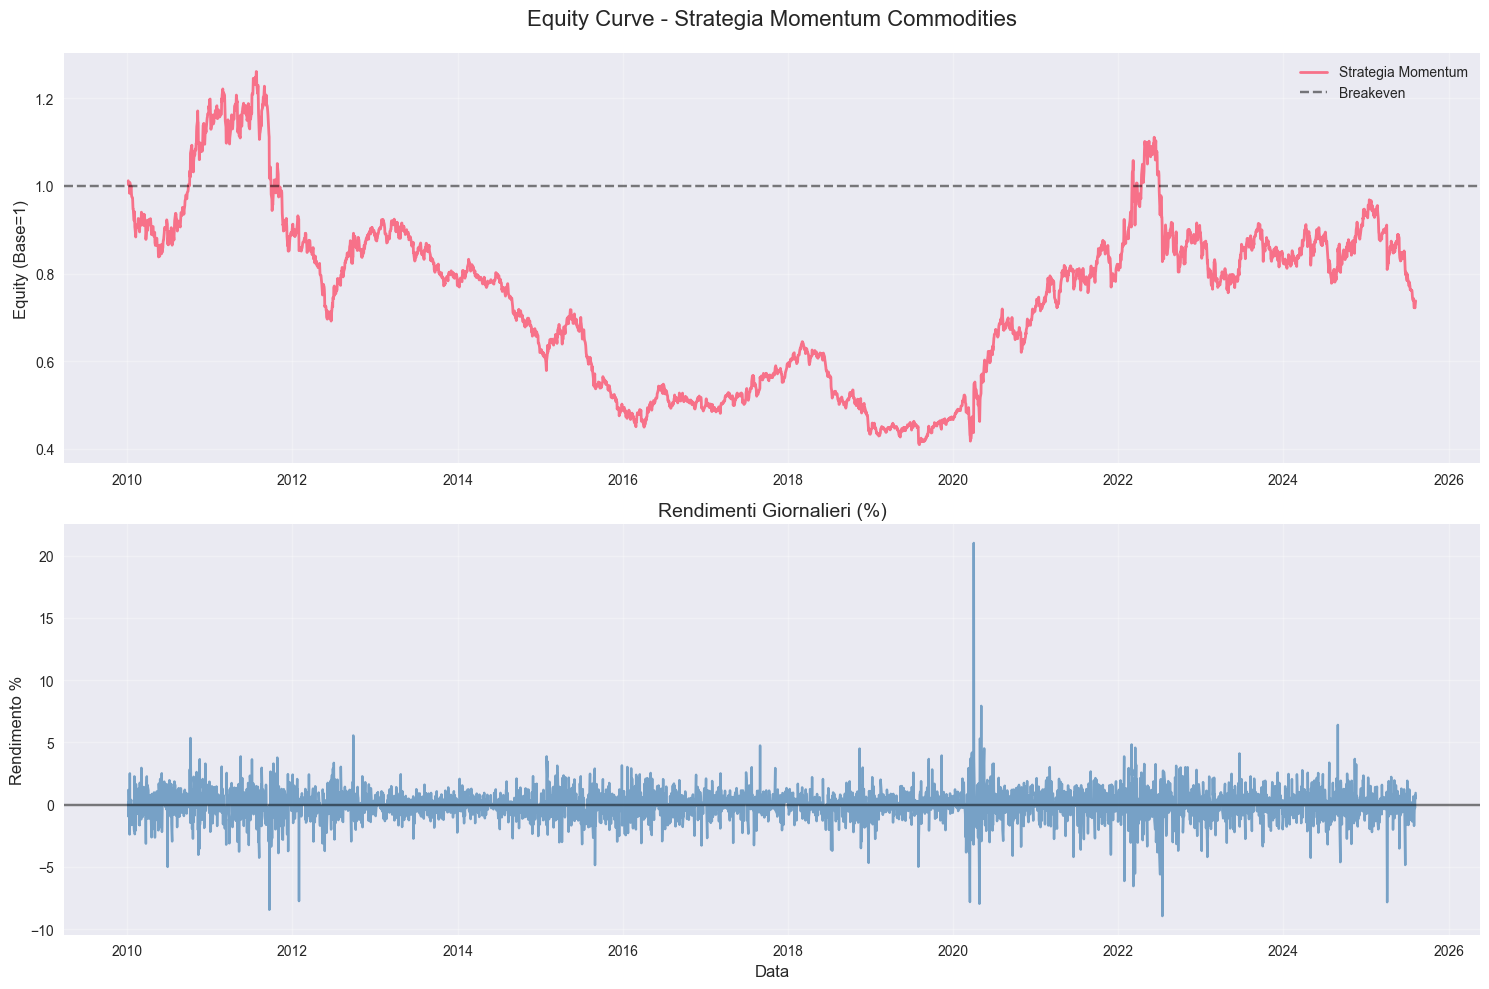


=== STATISTICHE STRATEGIA MOMENTUM ===
Rendimento totale: -26.25%
Rendimento annualizzato: -1.94%
Volatilità annualizzata: 20.27%
Sharpe ratio: -0.10
Max drawdown: -67.55%


In [7]:
# Grafico principale - Equity Curve
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Equity curve
ax1.plot(equity_curve.index, equity_curve.values, linewidth=2, label='Strategia Momentum')
ax1.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Breakeven')
ax1.set_title('Equity Curve - Strategia Momentum Commodities', fontsize=16, pad=20)
ax1.set_ylabel('Equity (Base=1)', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Rendimenti giornalieri
ax2.plot(strategy_returns.index, strategy_returns.values * 100, alpha=0.7, color='steelblue')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax2.set_title('Rendimenti Giornalieri (%)', fontsize=14)
ax2.set_ylabel('Rendimento %', fontsize=12)
ax2.set_xlabel('Data', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiche di base
total_return = equity_curve.iloc[-1] - 1
annualized_return = (1 + total_return) ** (252 / len(strategy_returns)) - 1
volatility = strategy_returns.std() * np.sqrt(252)
sharpe_ratio = annualized_return / volatility if volatility > 0 else 0
max_dd = ((equity_curve / equity_curve.expanding().max()) - 1).min()

print("\n=== STATISTICHE STRATEGIA MOMENTUM ===")
print(f"Rendimento totale: {total_return:.2%}")
print(f"Rendimento annualizzato: {annualized_return:.2%}")
print(f"Volatilità annualizzata: {volatility:.2%}")
print(f"Sharpe ratio: {sharpe_ratio:.2f}")
print(f"Max drawdown: {max_dd:.2%}")

## 3. Analisi Drawdown

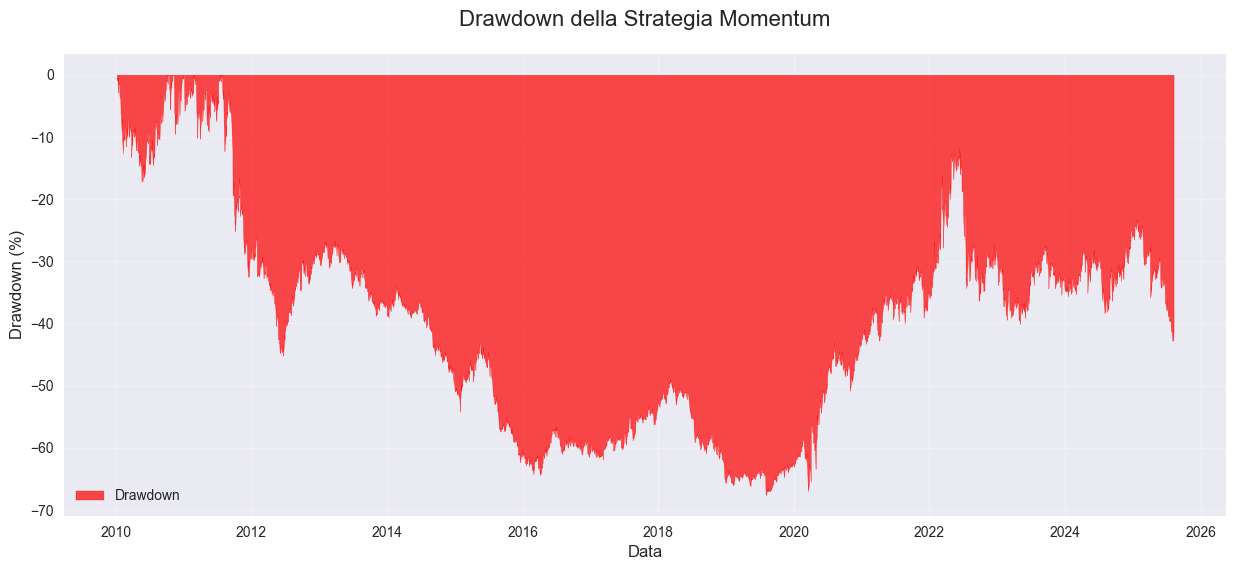

In [8]:
# Calcola drawdown rolling
rolling_max = equity_curve.expanding().max()
drawdown = (equity_curve / rolling_max) - 1

# Grafico drawdown
fig, ax = plt.subplots(figsize=(15, 6))
ax.fill_between(drawdown.index, drawdown.values * 100, 0, alpha=0.7, color='red', label='Drawdown')
ax.set_title('Drawdown della Strategia Momentum', fontsize=16, pad=20)
ax.set_ylabel('Drawdown (%)', fontsize=12)
ax.set_xlabel('Data', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

# Trova i periodi di drawdown più lunghi
dd_periods = []
in_drawdown = False
start_dd = None

for date, dd in drawdown.items():
    if dd < -0.01 and not in_drawdown:  # Inizia drawdown (>1%)
        in_drawdown = True
        start_dd = date
        min_dd = dd
    elif dd < -0.01 and in_drawdown:
        min_dd = min(min_dd, dd)
    elif dd >= -0.01 and in_drawdown:  # Fine drawdown
        in_drawdown = False
        duration = (date - start_dd).days
        dd_periods.append({
            'start': start_dd,
            'end': date,
            'duration_days': duration,
            'max_dd': min_dd
        })


## 4. Analisi Allocazione e Pesi

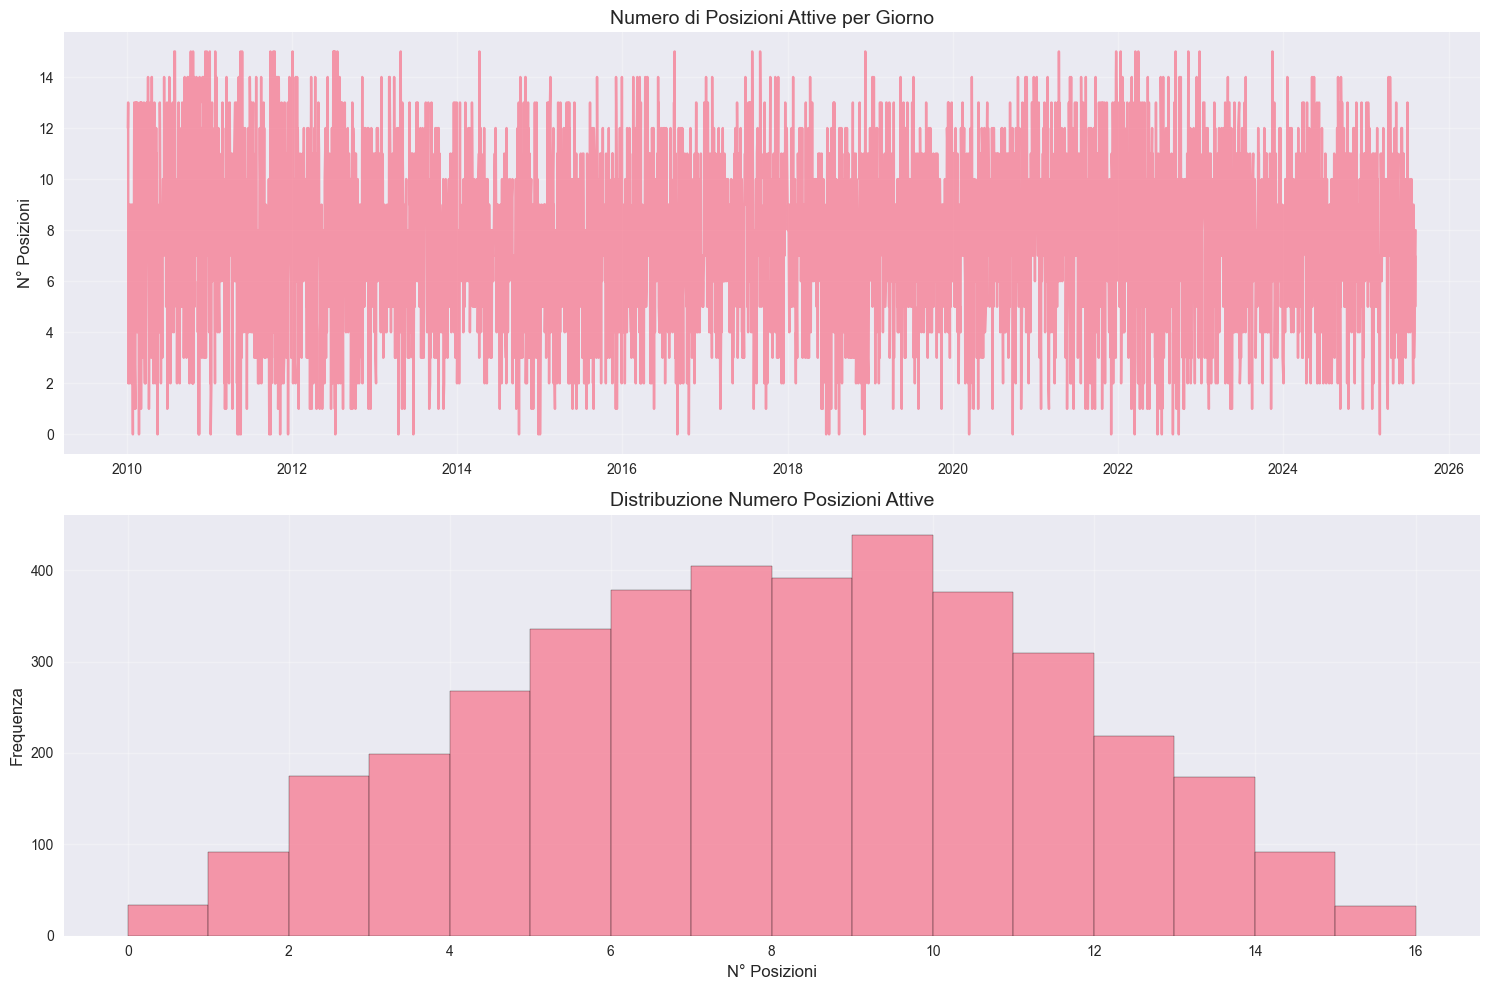


=== STATISTICHE ALLOCAZIONE ===
Numero medio posizioni attive: 7.6
Numero mediano posizioni attive: 8.0
Max posizioni contemporanee: 15
Giorni senza posizioni: 34 (0.9%)


In [9]:
# Analisi dei pesi nel tempo
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Numero di posizioni attive per giorno
n_positions = (weights > 0).sum(axis=1)
ax1.plot(n_positions.index, n_positions.values, alpha=0.7)
ax1.set_title('Numero di Posizioni Attive per Giorno', fontsize=14)
ax1.set_ylabel('N° Posizioni', fontsize=12)
ax1.grid(True, alpha=0.3)

# Istogramma distribuzione numero posizioni
ax2.hist(n_positions.values, bins=range(0, 17), alpha=0.7, edgecolor='black')
ax2.set_title('Distribuzione Numero Posizioni Attive', fontsize=14)
ax2.set_xlabel('N° Posizioni', fontsize=12)
ax2.set_ylabel('Frequenza', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== STATISTICHE ALLOCAZIONE ===")
print(f"Numero medio posizioni attive: {n_positions.mean():.1f}")
print(f"Numero mediano posizioni attive: {n_positions.median():.1f}")
print(f"Max posizioni contemporanee: {n_positions.max()}")
print(f"Giorni senza posizioni: {(n_positions == 0).sum()} ({(n_positions == 0).mean():.1%})")

## 5. Analisi per Commodity

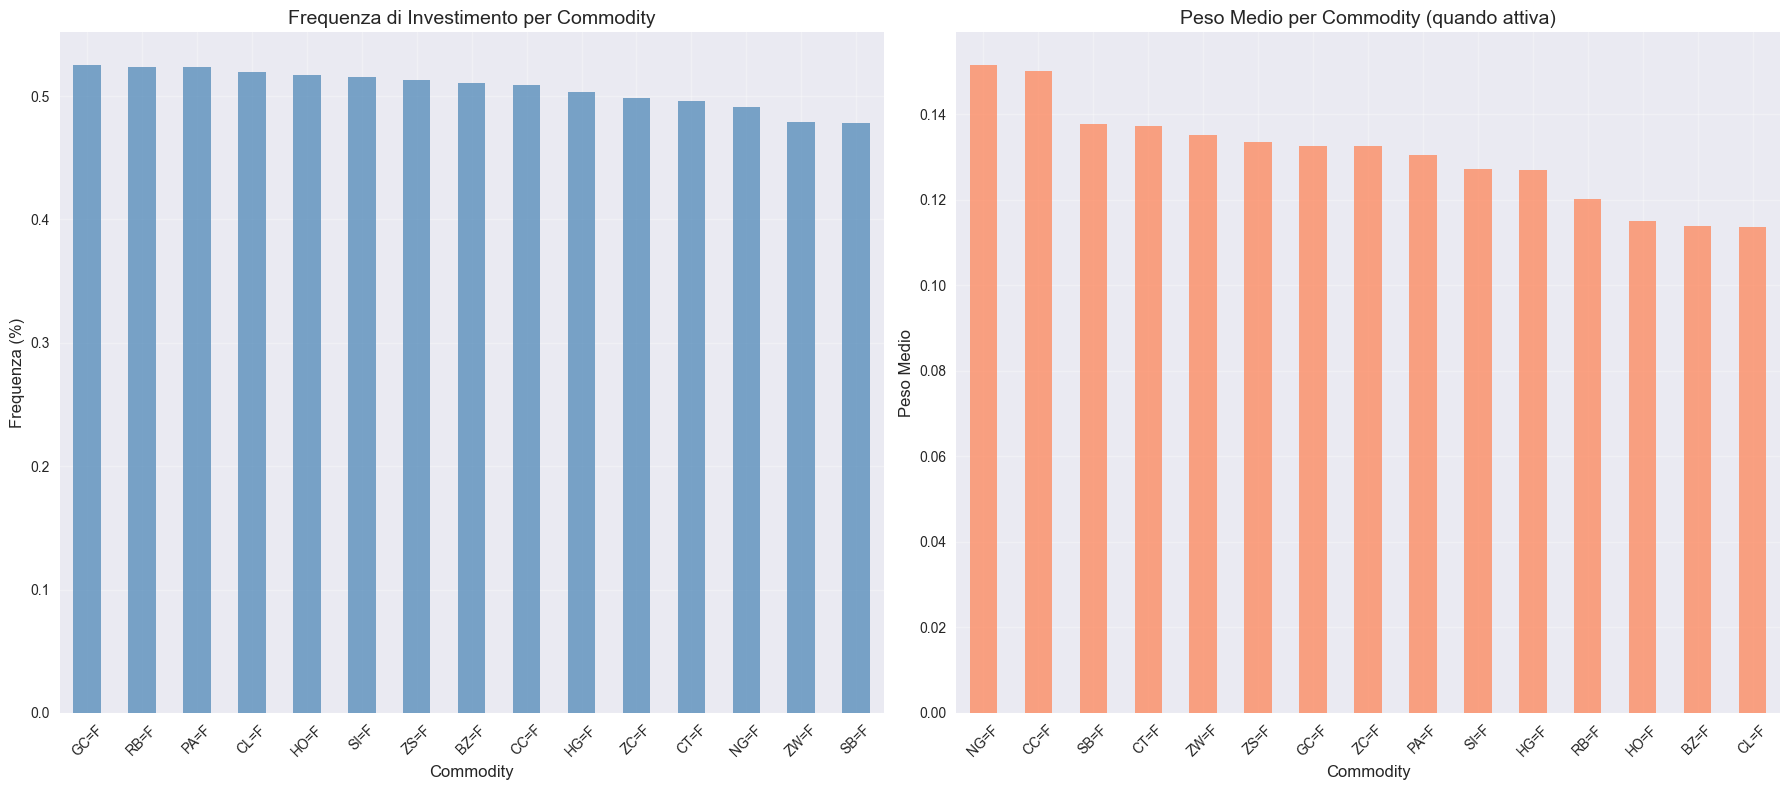


=== TOP 5 COMMODITY PER FREQUENZA DI INVESTIMENTO ===
GC=F: 52.5%
RB=F: 52.4%
PA=F: 52.4%
CL=F: 52.0%
HO=F: 51.7%


In [10]:
# Frequenza di investimento per commodity
investment_freq = (weights > 0).mean().sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Grafico a barre frequenza investimento
investment_freq.plot(kind='bar', ax=ax1, color='steelblue', alpha=0.7)
ax1.set_title('Frequenza di Investimento per Commodity', fontsize=14)
ax1.set_ylabel('Frequenza (%)', fontsize=12)
ax1.set_xlabel('Commodity', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Peso medio per commodity (quando investita)
avg_weight = weights[weights > 0].mean().sort_values(ascending=False)
avg_weight.plot(kind='bar', ax=ax2, color='coral', alpha=0.7)
ax2.set_title('Peso Medio per Commodity (quando attiva)', fontsize=14)
ax2.set_ylabel('Peso Medio', fontsize=12)
ax2.set_xlabel('Commodity', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== TOP 5 COMMODITY PER FREQUENZA DI INVESTIMENTO ===")
for commodity, freq in investment_freq.head().items():
    print(f"{commodity}: {freq:.1%}")

## 6. Analisi Rendimenti

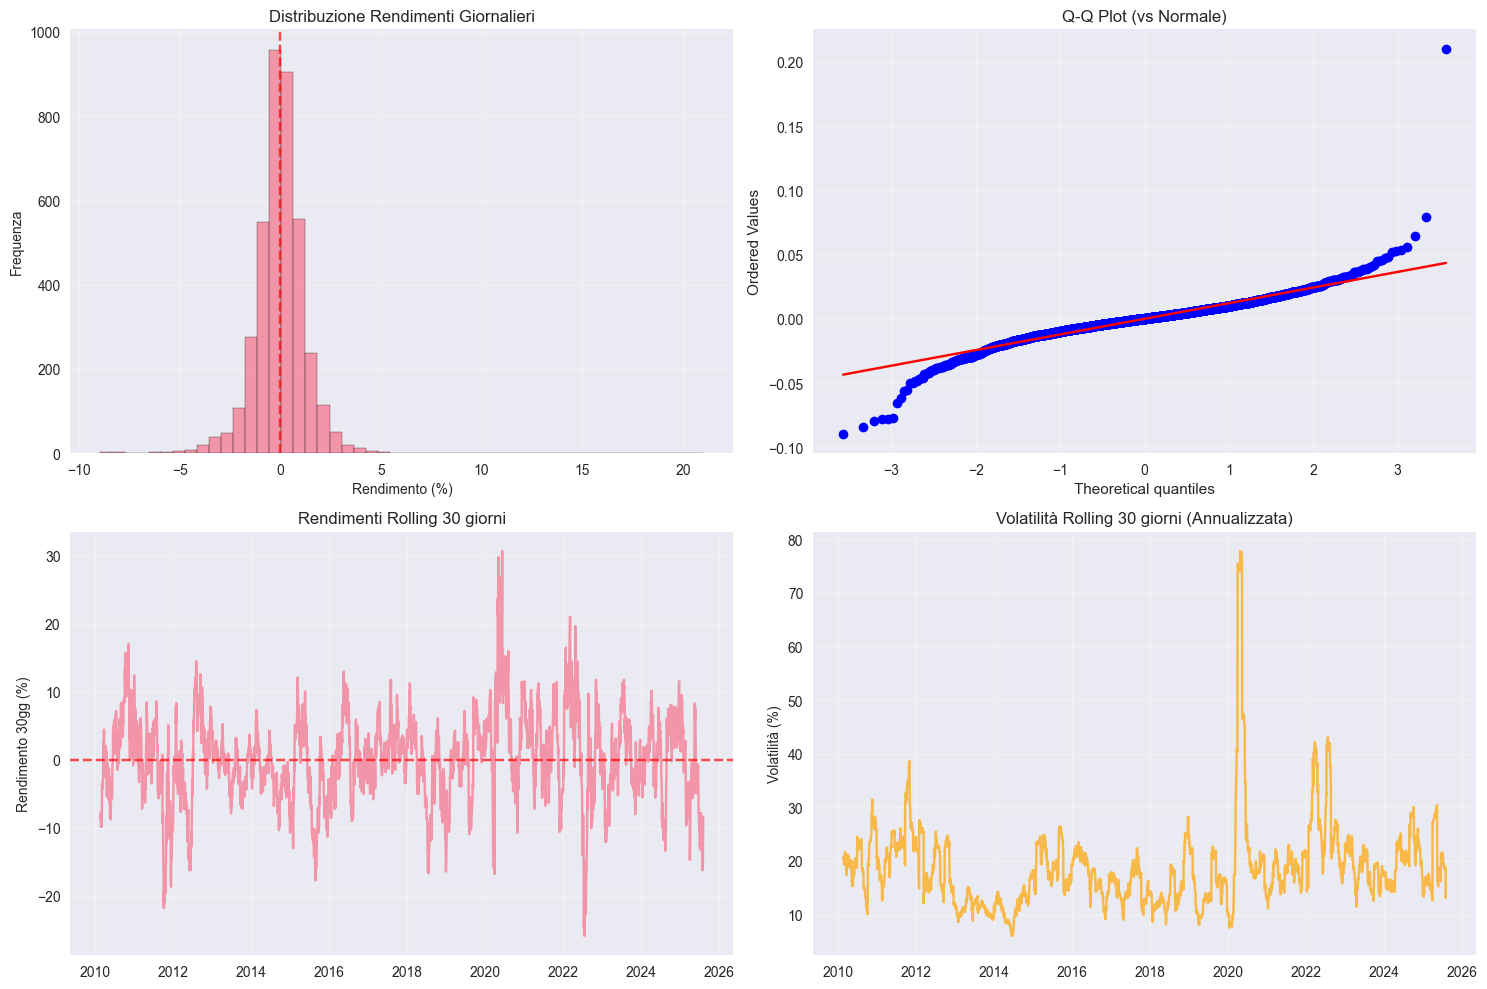


=== STATISTICHE DISTRIBUZIONE RENDIMENTI ===
Media: 0.0000 (0.09% ann.)
Mediana: 0.0001
Std Dev: 0.0128 (20.27% ann.)
Skewness: 0.69
Kurtosis: 22.82
Giorni positivi: 1985 (50.6%)
Giorni negativi: 1902 (48.5%)


In [11]:
# Distribuzione rendimenti giornalieri
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Istogramma rendimenti
ax1.hist(strategy_returns.values * 100, bins=50, alpha=0.7, edgecolor='black')
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.7)
ax1.set_title('Distribuzione Rendimenti Giornalieri', fontsize=12)
ax1.set_xlabel('Rendimento (%)', fontsize=10)
ax1.set_ylabel('Frequenza', fontsize=10)
ax1.grid(True, alpha=0.3)

# Q-Q plot per normalità
from scipy import stats
stats.probplot(strategy_returns.values, dist="norm", plot=ax2)
ax2.set_title('Q-Q Plot (vs Normale)', fontsize=12)
ax2.grid(True, alpha=0.3)

# Rendimenti rolling 30 giorni
rolling_returns = strategy_returns.rolling(30).sum()
ax3.plot(rolling_returns.index, rolling_returns.values * 100, alpha=0.7)
ax3.axhline(y=0, color='red', linestyle='--', alpha=0.7)
ax3.set_title('Rendimenti Rolling 30 giorni', fontsize=12)
ax3.set_ylabel('Rendimento 30gg (%)', fontsize=10)
ax3.grid(True, alpha=0.3)

# Volatilità rolling 30 giorni
rolling_vol = strategy_returns.rolling(30).std() * np.sqrt(252) * 100
ax4.plot(rolling_vol.index, rolling_vol.values, alpha=0.7, color='orange')
ax4.set_title('Volatilità Rolling 30 giorni (Annualizzata)', fontsize=12)
ax4.set_ylabel('Volatilità (%)', fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiche distribuzione
print("\n=== STATISTICHE DISTRIBUZIONE RENDIMENTI ===")
print(f"Media: {strategy_returns.mean():.4f} ({strategy_returns.mean()*252:.2%} ann.)")
print(f"Mediana: {strategy_returns.median():.4f}")
print(f"Std Dev: {strategy_returns.std():.4f} ({strategy_returns.std()*np.sqrt(252):.2%} ann.)")
print(f"Skewness: {strategy_returns.skew():.2f}")
print(f"Kurtosis: {strategy_returns.kurtosis():.2f}")
print(f"Giorni positivi: {(strategy_returns > 0).sum()} ({(strategy_returns > 0).mean():.1%})")
print(f"Giorni negativi: {(strategy_returns < 0).sum()} ({(strategy_returns < 0).mean():.1%})")

## 7. Performance Mensile e Annuale

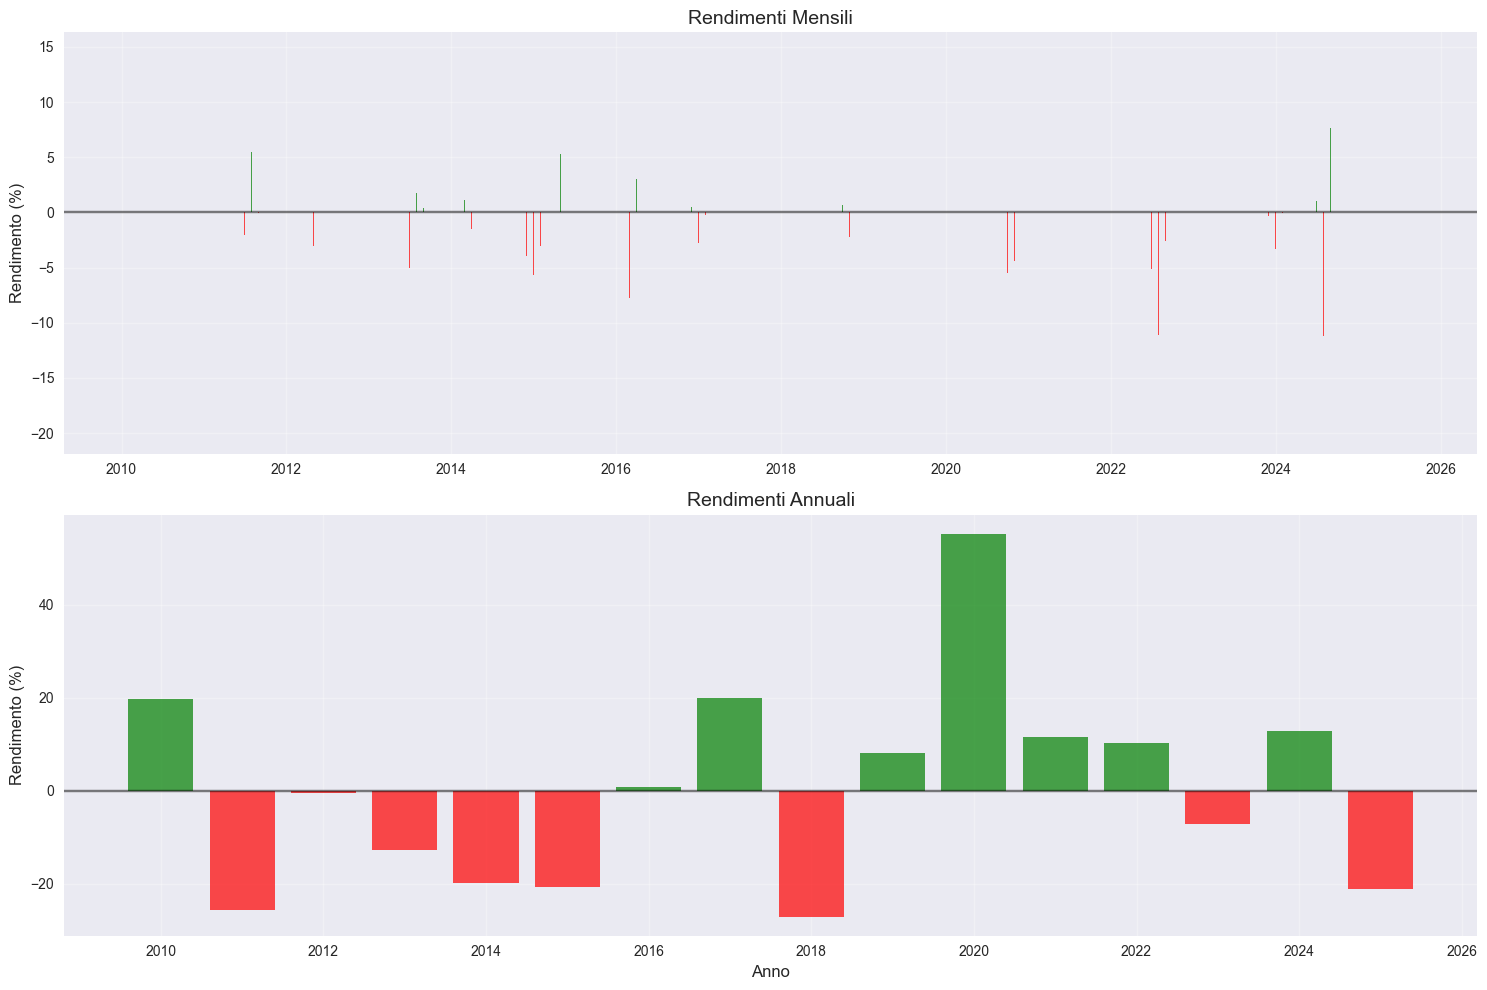


=== PERFORMANCE ANNUALE ===
2010: 19.66%
2011: -25.54%
2012: -0.59%
2013: -12.72%
2014: -19.86%
2015: -20.67%
2016: 0.78%
2017: 19.83%
2018: -27.06%
2019: 8.01%
2020: 55.25%
2021: 11.60%
2022: 10.32%
2023: -7.25%
2024: 12.78%
2025: -21.12%

=== STATISTICHE MENSILI ===
Mesi positivi: 93/188 (49.5%)
Miglior mese: 14.59% (2020-05)
Peggior mese: -20.12% (2011-09)


In [12]:
# Performance mensile
monthly_returns = strategy_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)

# Performance annuale
yearly_returns = strategy_returns.resample('Y').apply(lambda x: (1 + x).prod() - 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Rendimenti mensili
colors = ['green' if x > 0 else 'red' for x in monthly_returns.values]
ax1.bar(monthly_returns.index, monthly_returns.values * 100, color=colors, alpha=0.7)
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax1.set_title('Rendimenti Mensili', fontsize=14)
ax1.set_ylabel('Rendimento (%)', fontsize=12)
ax1.grid(True, alpha=0.3)

# Rendimenti annuali
colors_yearly = ['green' if x > 0 else 'red' for x in yearly_returns.values]
ax2.bar(yearly_returns.index.year, yearly_returns.values * 100, color=colors_yearly, alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax2.set_title('Rendimenti Annuali', fontsize=14)
ax2.set_ylabel('Rendimento (%)', fontsize=12)
ax2.set_xlabel('Anno', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== PERFORMANCE ANNUALE ===")
for year, ret in yearly_returns.items():
    print(f"{year.year}: {ret:.2%}")

print(f"\n=== STATISTICHE MENSILI ===")
print(f"Mesi positivi: {(monthly_returns > 0).sum()}/{len(monthly_returns)} ({(monthly_returns > 0).mean():.1%})")
print(f"Miglior mese: {monthly_returns.max():.2%} ({monthly_returns.idxmax().strftime('%Y-%m')})")
print(f"Peggior mese: {monthly_returns.min():.2%} ({monthly_returns.idxmin().strftime('%Y-%m')})")

## 8. Conclusioni e Considerazioni

### Risultati Chiave:
1. **Performance Negativa**: La strategia momentum a 1 giorno ha prodotto rendimenti negativi
2. **Alta Volatilità**: Volatilità significativa rispetto al rendimento
3. **Drawdown Elevati**: Max drawdown significativo

### Possibili Spiegazioni:
- Il momentum a 1 giorno potrebbe essere troppo breve per le commodity
- Le commodity potrebbero avere caratteristiche mean-reverting piuttosto che momentum
- I costi di transazione (non inclusi) potrebbero erodere ulteriormente i profitti

### Possibili Miglioramenti:
- Testare finestre momentum più lunghe (5, 10, 20 giorni)
- Includere filtri di volatilità o trend
- Considerare strategie contrarian
- Includere costi di transazione realistici

In [13]:
# Summary finale
print("\n" + "="*60)
print("         RIASSUNTO STRATEGIA MOMENTUM COMMODITIES")
print("="*60)
print(f"Periodo: {strategy_returns.index.min().date()} - {strategy_returns.index.max().date()}")
print(f"Commodity: {weights.shape[1]}")
print(f"Giorni di trading: {len(strategy_returns):,}")
print(f"")
print(f"Rendimento totale: {total_return:.2%}")
print(f"Rendimento annualizzato: {annualized_return:.2%}")
print(f"Volatilità annualizzata: {volatility:.2%}")
print(f"Sharpe ratio: {sharpe_ratio:.2f}")
print(f"Max drawdown: {max_dd:.2%}")
print(f"")
print(f"Posizioni attive medie: {n_positions.mean():.1f}")
print(f"Giorni senza posizioni: {(n_positions == 0).mean():.1%}")
print(f"Win rate giornaliero: {(strategy_returns > 0).mean():.1%}")
print("="*60)


         RIASSUNTO STRATEGIA MOMENTUM COMMODITIES
Periodo: 2010-01-06 - 2025-08-08
Commodity: 15
Giorni di trading: 3,921

Rendimento totale: -26.25%
Rendimento annualizzato: -1.94%
Volatilità annualizzata: 20.27%
Sharpe ratio: -0.10
Max drawdown: -67.55%

Posizioni attive medie: 7.6
Giorni senza posizioni: 0.9%
Win rate giornaliero: 50.6%
